Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ADVERSARIAL ROBUSTNESS ANALYSIS

Device: cuda
GPU: Tesla T4
Mixed Precision: True
Output Directory: /content/drive/MyDrive/CombinedDataset/adversarial_results
LOADING DATASETS

 Test:  2425 samples (76 batches)
Train: 20960 samples (655 batches)
Val:   2430 samples (76 batches)

Loading model
Model loaded from: /content/drive/MyDrive/CombinedDataset/results_resnet18/best_resnet18.pth
PHASE 1: ORIGINAL MODEL EVALUATION

1. Clean Test Accuracy:


   Accuracy: 99.96%

2. FGSM Attack Results:


FGSM ε=0.001:   0%|          | 0/76 [00:00<?, ?it/s]/tmp/ipython-input-3325847793.py:172: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


   ε = 0.001: 92.74%


   ε = 0.005: 91.96%


   ε = 0.010: 91.79%


   ε = 0.020: 91.75%


   ε = 0.050: 91.96%

3. PGD Attack Result:


   Accuracy: 0.00%
   Attack Time: 80.9 seconds
ORIGINAL MODEL SUMMARY
Clean Accuracy:        99.96%
FGSM-0.01 Accuracy:    91.79%
PGD-0.01 Accuracy:     0.00%
Robustness Drop (PGD): 99.96%
PHASE 2: ADVERSARIAL TRAINING

Proceed with adversarial training? (y/n): n

Adversarial training skipped.

 can still use the Phase 1 results to analyze the original model's vulnerabilities.

Phase 1 results saved to: /content/drive/MyDrive/CombinedDataset/adversarial_results/phase1_results.json
Robustness curve saved


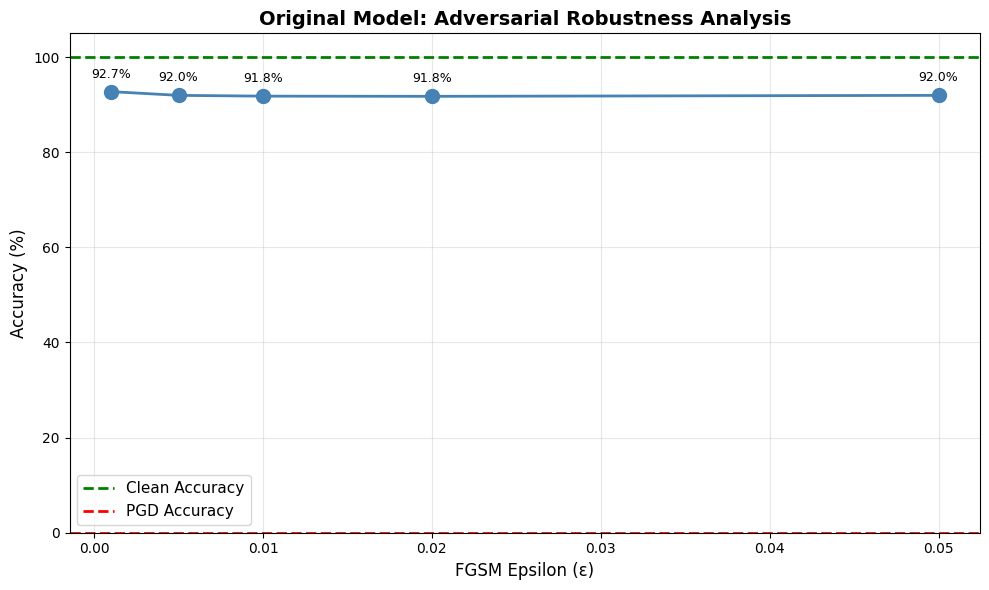

PHASE 1 ANALYSIS COMPLETE


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
from sklearn.metrics import classification_report, confusion_matrix
import time


#congfig


class Config:
    # Paths
    DATA_ROOT = "/content/drive/MyDrive/CombinedDataset"
    MODEL_PATH = "/content/drive/MyDrive/CombinedDataset/results_resnet18/best_resnet18.pth"
    OUT_DIR = "/content/drive/MyDrive/CombinedDataset/adversarial_results"

    # Model settings
    IMG_SIZE = 224
    BATCH_SIZE = 32  # INCREASED from 32 - processes more data per iteration #32->64->128
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Adversarial attack settings
    EPSILON_VALUES = [0.001, 0.005, 0.01, 0.02, 0.05]
    PGD_EPSILON = 0.01
    PGD_ALPHA = 0.002
    PGD_ITERATIONS = 10

    # Adversarial training settings (SUPER OPTIMIZED)
    ADV_TRAIN_EPOCHS = 5 #10->5
    ADV_TRAIN_LR = 2e-4  # Slightly higher LR for faster convergence
    ADV_TRAIN_EPSILON = 0.01
    WEIGHT_DECAY = 1e-4

    # Optimization settings
    USE_AMP = True  # Automatic Mixed Precision
    NUM_WORKERS = 4  # INCREASED from 2 - more parallel data loading
    PREFETCH_FACTOR = 2  # Prefetch batches
    PERSISTENT_WORKERS = True  # Keep workers alive between epochs

    # Training optimizations
    ADV_RATIO = 0.3  # REDUCED from 0.5 - only 30% adversarial examples (faster)
    GRADIENT_ACCUMULATION = 1  # Number of steps to accumulate gradients

    # Reproducibility
    SEED = 42

config = Config()
os.makedirs(config.OUT_DIR, exist_ok=True)

# Set random seeds
np.random.seed(config.SEED)
torch.manual_seed(config.SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(config.SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


print("ADVERSARIAL ROBUSTNESS ANALYSIS")

print(f"\nDevice: {config.DEVICE}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"Mixed Precision: {config.USE_AMP}")
print(f"Output Directory: {config.OUT_DIR}")


#dataset class


class MelSpectrogramDataset(Dataset):
    """Dataset for loading mel spectrogram .npy files"""

    def __init__(self, root_dir, img_size=224, augment=False):
        self.root_dir = os.path.join(root_dir, "mel")
        self.img_size = img_size
        self.augment = augment
        self.files = []
        self.labels = []

        # Load file paths
        for label_name, label_id in [('real', 0), ('fake', 1)]:
            folder = os.path.join(self.root_dir, label_name)
            if not os.path.exists(folder):
                raise ValueError(f"Folder not found: {folder}")

            for filename in os.listdir(folder):
                if filename.lower().endswith('.npy'):
                    self.files.append(os.path.join(folder, filename))
                    self.labels.append(label_id)

        if len(self.files) == 0:
            raise ValueError(f"No .npy files found in {self.root_dir}")

        # Shuffle dataset
        combined = list(zip(self.files, self.labels))
        np.random.shuffle(combined)
        self.files, self.labels = zip(*combined)

        # Transforms
        self.to_pil = transforms.ToPILImage()
        self.resize = transforms.Resize((img_size, img_size))
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        # Load mel spectrogram
        mel_spec = np.load(self.files[idx])

        # Convert to 3-channel
        if mel_spec.ndim == 2:
            mel_spec = np.stack([mel_spec] * 3, axis=-1)

        # Normalize to [0, 255]
        mel_min, mel_max = mel_spec.min(), mel_spec.max()
        mel_normalized = ((mel_spec - mel_min) / (mel_max - mel_min + 1e-9) * 255).astype(np.uint8)

        # Convert to PIL and apply transforms
        image = self.to_pil(mel_normalized)
        image = self.resize(image)
        image = self.to_tensor(image)
        image = self.normalize(image)

        return image, self.labels[idx]


#loading model from drive


def load_model(model_path, device):
    """Load pretrained ResNet-18 model"""
    print("\nLoading model")
    model = models.resnet18(weights=None)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 2)

    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()

    print(f"Model loaded from: {model_path}")
    return model

#ADVERSARIAL ATTACKS (OPTIMIZED)


def fgsm_attack(model, images, labels, epsilon):
    """Fast Gradient Sign Method attack - OPTIMIZED"""
    images.requires_grad = True

    # Use mixed precision for attack generation too
    if config.USE_AMP and torch.cuda.is_available():
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
    else:
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)

    model.zero_grad()
    loss.backward()

    data_grad = images.grad.data
    sign_data_grad = data_grad.sign()
    perturbed_images = images + epsilon * sign_data_grad
    perturbed_images = torch.clamp(perturbed_images, images.min(), images.max())

    return perturbed_images.detach()

def pgd_attack(model, images, labels, epsilon, alpha, num_iterations):
    """Projected Gradient Descent attack"""
    original_images = images.clone().detach()
    perturbed_images = images.clone().detach()

    for i in range(num_iterations):
        perturbed_images.requires_grad = True

        outputs = model(perturbed_images)
        loss = F.cross_entropy(outputs, labels)

        model.zero_grad()
        loss.backward()

        data_grad = perturbed_images.grad.data
        perturbed_images = perturbed_images.detach() + alpha * data_grad.sign()

        # Project back to epsilon ball
        perturbation = torch.clamp(perturbed_images - original_images, -epsilon, epsilon)
        perturbed_images = torch.clamp(original_images + perturbation,
                                       original_images.min(), original_images.max()).detach()

    return perturbed_images


#evaluation function


def evaluate_model(model, dataloader, device, attack_fn=None, attack_params=None, desc="Evaluating"):
    """Evaluate model on clean or adversarial examples"""
    model.eval()
    all_preds = []
    all_labels = []

    context = torch.no_grad() if attack_fn is None else torch.enable_grad()

    with context:
        for images, labels in tqdm(dataloader, desc=desc, leave=False):
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            #generate adversarial examples if needed
            if attack_fn is not None:
                images = attack_fn(model, images, labels, **attack_params)

            #get predictions
            with torch.no_grad():
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    accuracy = (all_preds == all_labels).mean()

    return accuracy, all_preds, all_labels


#ADVERSARIAL TRAINING (OPTIMIZED)


def adversarial_training(model, train_loader, val_loader, config):
    """Train model with adversarial examples - SUPER OPTIMIZED"""

    print("ADVERSARIAL TRAINING (SUPER OPTIMIZED)")


    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=config.ADV_TRAIN_LR,
        weight_decay=config.WEIGHT_DECAY
    )

    # Mixed precision scaler
    scaler = torch.cuda.amp.GradScaler() if config.USE_AMP and torch.cuda.is_available() else None
    use_amp = config.USE_AMP and torch.cuda.is_available()

    print(f"Optimizer: Adam (LR={config.ADV_TRAIN_LR})")
    print(f"Mixed Precision: {'Enabled' if use_amp else 'Disabled'}")
    print(f"Training Epsilon: {config.ADV_TRAIN_EPSILON}")
    print(f"Adversarial Ratio: {config.ADV_RATIO*100:.0f}%")
    print(f"Batch Size: {config.BATCH_SIZE}")
    print(f"Epochs: {config.ADV_TRAIN_EPOCHS}")

    best_val_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_acc': [], 'epoch_time': []}

    for epoch in range(config.ADV_TRAIN_EPOCHS):
        epoch_start_time = time.time()

        print(f"Epoch {epoch+1}/{config.ADV_TRAIN_EPOCHS}")


        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc="Training", leave=False):
            images = images.to(config.DEVICE, non_blocking=True)
            labels = labels.to(config.DEVICE, non_blocking=True)

            # Split batch: ADV_RATIO adversarial, rest clean
            batch_size = images.size(0)
            adv_size = int(batch_size * config.ADV_RATIO)

            clean_images = images[adv_size:]
            clean_labels = labels[adv_size:]

            adv_images_raw = images[:adv_size]
            adv_labels = labels[:adv_size]

            # Generate adversarial examples (with mixed precision)
            if adv_size > 0:
                with torch.enable_grad():
                    adv_images = fgsm_attack(model, adv_images_raw, adv_labels, config.ADV_TRAIN_EPSILON)

                # Combine clean and adversarial
                combined_images = torch.cat([clean_images, adv_images], dim=0)
                combined_labels = torch.cat([clean_labels, adv_labels], dim=0)
            else:
                combined_images = clean_images
                combined_labels = clean_labels

            # Forward pass with mixed precision
            optimizer.zero_grad(set_to_none=True)

            if use_amp:
                with torch.cuda.amp.autocast():
                    outputs = model(combined_images)
                    loss = criterion(outputs, combined_labels)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(combined_images)
                loss = criterion(outputs, combined_labels)
                loss.backward()
                optimizer.step()

            # Statistics
            running_loss += loss.item() * combined_images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += combined_labels.size(0)
            correct += (predicted == combined_labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total

        # Validation phase
        val_acc, _, _ = evaluate_model(model, val_loader, config.DEVICE, desc="Validation")

        epoch_time = time.time() - epoch_start_time

        # Save history
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        history['val_acc'].append(val_acc)
        history['epoch_time'].append(epoch_time)

        # Print results
        print(f"\nTrain Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f}")
        print(f"Val Acc:    {val_acc:.4f}")
        print(f"Epoch Time: {epoch_time/60:.2f} minutes")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(),
                      os.path.join(config.OUT_DIR, "adversarial_trained_model.pth"))
            print(f"Best model saved (Val Acc: {val_acc:.4f})")

    total_time = sum(history['epoch_time'])

    print(f"Training Complete!")
    print(f"Total Time: {total_time/60:.2f} minutes")
    print(f"Average Time per Epoch: {total_time/config.ADV_TRAIN_EPOCHS/60:.2f} minutes")
    print(f"Best Val Accuracy: {best_val_acc:.4f}")


    return model, history


#main exectuion

print("LOADING DATASETS")


# Load datasets
test_dataset = MelSpectrogramDataset(
    os.path.join(config.DATA_ROOT, "test"),
    img_size=config.IMG_SIZE
)

train_dataset = MelSpectrogramDataset(
    os.path.join(config.DATA_ROOT, "train"),
    img_size=config.IMG_SIZE
)

val_dataset = MelSpectrogramDataset(
    os.path.join(config.DATA_ROOT, "val"),
    img_size=config.IMG_SIZE
)

# Create dataloaders with SUPER optimizations
test_loader = DataLoader(
    test_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    num_workers=config.NUM_WORKERS,
    pin_memory=True,
    prefetch_factor=config.PREFETCH_FACTOR,
    persistent_workers=config.PERSISTENT_WORKERS
)

train_loader = DataLoader(
    train_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=True,
    num_workers=config.NUM_WORKERS,
    pin_memory=True,
    prefetch_factor=config.PREFETCH_FACTOR,
    persistent_workers=config.PERSISTENT_WORKERS
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    num_workers=config.NUM_WORKERS,
    pin_memory=True,
    prefetch_factor=config.PREFETCH_FACTOR,
    persistent_workers=config.PERSISTENT_WORKERS
)

print(f"\n Test:  {len(test_dataset)} samples ({len(test_loader)} batches)")
print(f"Train: {len(train_dataset)} samples ({len(train_loader)} batches)")
print(f"Val:   {len(val_dataset)} samples ({len(val_loader)} batches)")

# Load original model
original_model = load_model(config.MODEL_PATH, config.DEVICE)

#PHASE 1: TEST ORIGINAL MODEL



print("PHASE 1: ORIGINAL MODEL EVALUATION")

print("\n1. Clean Test Accuracy:")
clean_acc, clean_preds, clean_labels = evaluate_model(
    original_model, test_loader, config.DEVICE, desc="Clean Test"
)
print(f"   Accuracy: {clean_acc*100:.2f}%")

print("\n2. FGSM Attack Results:")
fgsm_results = {}
for epsilon in config.EPSILON_VALUES:
    acc, _, _ = evaluate_model(
        original_model, test_loader, config.DEVICE,
        attack_fn=fgsm_attack,
        attack_params={'epsilon': epsilon},
        desc=f"FGSM ε={epsilon}"
    )
    fgsm_results[epsilon] = acc
    print(f"   ε = {epsilon:.3f}: {acc*100:.2f}%")

print("\n3. PGD Attack Result:")
pgd_start = time.time()
pgd_acc, pgd_preds, pgd_labels = evaluate_model(
    original_model, test_loader, config.DEVICE,
    attack_fn=pgd_attack,
    attack_params={
        'epsilon': config.PGD_EPSILON,
        'alpha': config.PGD_ALPHA,
        'num_iterations': config.PGD_ITERATIONS
    },
    desc="PGD Attack"
)
pgd_time = time.time() - pgd_start
print(f"   Accuracy: {pgd_acc*100:.2f}%")
print(f"   Attack Time: {pgd_time:.1f} seconds")

# Print summary

print("ORIGINAL MODEL SUMMARY")

print(f"Clean Accuracy:        {clean_acc*100:.2f}%")
print(f"FGSM-0.01 Accuracy:    {fgsm_results[0.01]*100:.2f}%")
print(f"PGD-0.01 Accuracy:     {pgd_acc*100:.2f}%")
print(f"Robustness Drop (PGD): {(clean_acc - pgd_acc)*100:.2f}%")


#PHASE 2: ADVERSARIAL TRAINING



print("PHASE 2: ADVERSARIAL TRAINING")


response = input("\nProceed with adversarial training? (y/n): ")

if response.lower() == 'y':
    # Load fresh model for adversarial training
    adv_model = load_model(config.MODEL_PATH, config.DEVICE)

    # Train with adversarial examples
    adv_model, adv_history = adversarial_training(adv_model, train_loader, val_loader, config)


    #PHASE 3: TEST ADVERSARIALLY TRAINED MODEL



    print("PHASE 3: ADVERSARIALLY TRAINED MODEL EVALUATION")


    print("\n1. Clean Test Accuracy:")
    adv_clean_acc, _, _ = evaluate_model(
        adv_model, test_loader, config.DEVICE, desc="Clean Test"
    )
    print(f"   Accuracy: {adv_clean_acc*100:.2f}%")
    print(f"   Change: {(adv_clean_acc - clean_acc)*100:+.2f}%")

    print("\n2. FGSM Attack Results:")
    adv_fgsm_results = {}
    for epsilon in config.EPSILON_VALUES:
        acc, _, _ = evaluate_model(
            adv_model, test_loader, config.DEVICE,
            attack_fn=fgsm_attack,
            attack_params={'epsilon': epsilon},
            desc=f"FGSM ε={epsilon}"
        )
        adv_fgsm_results[epsilon] = acc
        improvement = (acc - fgsm_results[epsilon]) * 100
        print(f"   ε = {epsilon:.3f}: {acc*100:.2f}% (Δ {improvement:+.2f}%)")

    print("\n3. PGD Attack Result:")
    adv_pgd_acc, _, _ = evaluate_model(
        adv_model, test_loader, config.DEVICE,
        attack_fn=pgd_attack,
        attack_params={
            'epsilon': config.PGD_EPSILON,
            'alpha': config.PGD_ALPHA,
            'num_iterations': config.PGD_ITERATIONS
        },
        desc="PGD Attack"
    )
    pgd_improvement = (adv_pgd_acc - pgd_acc) * 100
    print(f"   Accuracy: {adv_pgd_acc*100:.2f}% (Δ {pgd_improvement:+.2f}%)")


    #plots, visualizations



    print("GENERATING VISUALIZATIONS")


    # Plot 1: Robustness Comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # FGSM comparison
    epsilons = list(fgsm_results.keys())
    original_fgsm = [fgsm_results[e]*100 for e in epsilons]
    adversarial_fgsm = [adv_fgsm_results[e]*100 for e in epsilons]

    ax1.plot(epsilons, original_fgsm, 'o-', label='Original Model', linewidth=2, markersize=8)
    ax1.plot(epsilons, adversarial_fgsm, 's-', label='Adversarially Trained', linewidth=2, markersize=8)
    ax1.set_xlabel('Epsilon (ε)', fontsize=12)
    ax1.set_ylabel('Accuracy (%)', fontsize=12)
    ax1.set_title('FGSM Attack Robustness Comparison', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(alpha=0.3)
    ax1.set_ylim([0, 105])

    # Overall comparison
    categories = ['Clean', 'FGSM\nε=0.01', 'PGD\nε=0.01']
    original_scores = [clean_acc*100, fgsm_results[0.01]*100, pgd_acc*100]
    adversarial_scores = [adv_clean_acc*100, adv_fgsm_results[0.01]*100, adv_pgd_acc*100]

    x = np.arange(len(categories))
    width = 0.35

    bars1 = ax2.bar(x - width/2, original_scores, width, label='Original Model', color='steelblue')
    bars2 = ax2.bar(x + width/2, adversarial_scores, width, label='Adversarially Trained', color='coral')

    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.set_title('Overall Performance Comparison', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(categories, fontsize=11)
    ax2.legend(fontsize=11)
    ax2.grid(alpha=0.3, axis='y')
    ax2.set_ylim([0, 105])

    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.savefig(os.path.join(config.OUT_DIR, 'adversarial_comparison.png'),
                dpi=300, bbox_inches='tight')
    print("Comparison plot saved")
    plt.show()

    # Plot 2: Training History
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    epochs = range(1, len(adv_history['train_loss']) + 1)

    ax1.plot(epochs, adv_history['train_loss'], 'o-', linewidth=2, markersize=8, color='crimson')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Adversarial Training Loss', fontsize=14, fontweight='bold')
    ax1.grid(alpha=0.3)

    ax2.plot(epochs, adv_history['train_acc'], 'o-', label='Train Accuracy', linewidth=2, markersize=8)
    ax2.plot(epochs, adv_history['val_acc'], 's-', label='Val Accuracy', linewidth=2, markersize=8)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_title('Adversarial Training Accuracy', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(config.OUT_DIR, 'adversarial_training_history.png'),
                dpi=300, bbox_inches='tight')
    print("Training history plot saved")
    plt.show()

    # Plot 3: Confusion Matrices
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Original model confusion matrix
    cm_original = confusion_matrix(clean_labels, clean_preds)
    sns.heatmap(cm_original, annot=True, fmt='d', cmap='Blues', ax=ax1,
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    ax1.set_title('Original Model (Clean Test)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('True Label', fontsize=12)
    ax1.set_xlabel('Predicted Label', fontsize=12)

    # Adversarial model under PGD attack
    adv_pgd_preds = evaluate_model(
        adv_model, test_loader, config.DEVICE,
        attack_fn=pgd_attack,
        attack_params={'epsilon': config.PGD_EPSILON, 'alpha': config.PGD_ALPHA,
                      'num_iterations': config.PGD_ITERATIONS}
    )[1]
    cm_adv = confusion_matrix(pgd_labels, adv_pgd_preds)
    sns.heatmap(cm_adv, annot=True, fmt='d', cmap='Oranges', ax=ax2,
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    ax2.set_title('Adversarially Trained (PGD Attack)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('True Label', fontsize=12)
    ax2.set_xlabel('Predicted Label', fontsize=12)

    plt.tight_layout()
    plt.savefig(os.path.join(config.OUT_DIR, 'confusion_matrices.png'),
                dpi=300, bbox_inches='tight')
    print("Confusion matrices saved")
    plt.show()

    # Save results to JSON
    results = {
        'original_model': {
            'clean_accuracy': float(clean_acc),
            'fgsm_results': {str(k): float(v) for k, v in fgsm_results.items()},
            'pgd_accuracy': float(pgd_acc)
        },
        'adversarial_model': {
            'clean_accuracy': float(adv_clean_acc),
            'fgsm_results': {str(k): float(v) for k, v in adv_fgsm_results.items()},
            'pgd_accuracy': float(adv_pgd_acc)
        },
        'improvements': {
            'clean_accuracy_change': float(adv_clean_acc - clean_acc),
            'fgsm_0.01_improvement': float(adv_fgsm_results[0.01] - fgsm_results[0.01]),
            'pgd_improvement': float(adv_pgd_acc - pgd_acc)
        },
        'training_history': {
            'train_loss': [float(x) for x in adv_history['train_loss']],
            'train_acc': [float(x) for x in adv_history['train_acc']],
            'val_acc': [float(x) for x in adv_history['val_acc']],
            'epoch_times': [float(x) for x in adv_history['epoch_time']]
        }
    }

    with open(os.path.join(config.OUT_DIR, 'adversarial_results.json'), 'w') as f:
        json.dump(results, f, indent=2)
    print("Results saved to adversarial_results.json")


    #sumamry


    print("\n" + "="*60)
    print("FINAL SUMMARY")
    print("="*60)

    print("\nORIGINAL MODEL:")
    print(f"   Clean Accuracy:     {clean_acc*100:.2f}%")
    print(f"   FGSM-0.01 Accuracy: {fgsm_results[0.01]*100:.2f}%")
    print(f"   PGD-0.01 Accuracy:  {pgd_acc*100:.2f}%")
    print(f"   Robustness Drop:    {(clean_acc - pgd_acc)*100:.2f}%")

    print("\nADVERSARIALLY TRAINED MODEL:")
    print(f"   Clean Accuracy:     {adv_clean_acc*100:.2f}% ({(adv_clean_acc-clean_acc)*100:+.2f}%)")
    print(f"   FGSM-0.01 Accuracy: {adv_fgsm_results[0.01]*100:.2f}% ({(adv_fgsm_results[0.01]-fgsm_results[0.01])*100:+.2f}%)")
    print(f"   PGD-0.01 Accuracy:  {adv_pgd_acc*100:.2f}% ({(adv_pgd_acc-pgd_acc)*100:+.2f}%)")
    print(f"   Robustness Drop:    {(adv_clean_acc - adv_pgd_acc)*100:.2f}%")

    print("\nIMPROVEMENTS:")
    print(f"   PGD Robustness Gain:      {(adv_pgd_acc - pgd_acc)*100:+.2f} percentage points")
    print(f"   FGSM-0.01 Robustness Gain: {(adv_fgsm_results[0.01] - fgsm_results[0.01])*100:+.2f} percentage points")
    print(f"   Clean Accuracy Trade-off:  {(adv_clean_acc - clean_acc)*100:+.2f} percentage points")

    # Calculate trade-off ratio
    robustness_gain = (adv_pgd_acc - pgd_acc) * 100
    clean_loss = abs((adv_clean_acc - clean_acc) * 100)
    if clean_loss > 0:
        trade_off_ratio = robustness_gain / clean_loss
        print(f"   Trade-off Ratio:          {trade_off_ratio:.2f}x (robustness gain per accuracy loss)")

    print("\nTRAINING EFFICIENCY:")
    avg_epoch_time = sum(adv_history['epoch_time']) / len(adv_history['epoch_time'])
    total_training_time = sum(adv_history['epoch_time'])
    print(f"   Total Training Time:  {total_training_time/60:.2f} minutes")
    print(f"   Average per Epoch:    {avg_epoch_time/60:.2f} minutes")
    print(f"   Samples per Second:   {len(train_loader.dataset) / avg_epoch_time:.1f}")

    print(f"\n All results saved to: {config.OUT_DIR}")
    print("   - adversarial_trained_model.pth")
    print("   - adversarial_results.json")
    print("   - adversarial_comparison.png")
    print("   - adversarial_training_history.png")
    print("   - confusion_matrices.png")


    print("ANALYSIS COMPLETE")


    # Generate classification reports
    print("\nDETAILED CLASSIFICATION REPORTS:")
    print("\nOriginal Model (Clean Test)")
    print(classification_report(clean_labels, clean_preds,
                                target_names=['Real', 'Fake'],
                                digits=4))

    print("\nOriginal Model (PGD Attack)")
    print(classification_report(pgd_labels, pgd_preds,
                                target_names=['Real', 'Fake'],
                                digits=4))

    print("\nAdversarially Trained Model (PGD Attack)")
    print(classification_report(pgd_labels, adv_pgd_preds,
                                target_names=['Real', 'Fake'],
                                digits=4))

else:
    print("\nAdversarial training skipped.")
    print("\n can still use the Phase 1 results to analyze the original model's vulnerabilities.")

    # Save Phase 1 results only
    phase1_results = {
        'original_model': {
            'clean_accuracy': float(clean_acc),
            'fgsm_results': {str(k): float(v) for k, v in fgsm_results.items()},
            'pgd_accuracy': float(pgd_acc),
            'robustness_drop': float(clean_acc - pgd_acc)
        }
    }

    with open(os.path.join(config.OUT_DIR, 'phase1_results.json'), 'w') as f:
        json.dump(phase1_results, f, indent=2)

    print(f"\nPhase 1 results saved to: {config.OUT_DIR}/phase1_results.json")

    # Generate simple visualization for Phase 1
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    epsilons = list(fgsm_results.keys())
    accuracies = [fgsm_results[e]*100 for e in epsilons]

    ax.plot(epsilons, accuracies, 'o-', linewidth=2, markersize=10, color='steelblue')
    ax.axhline(y=clean_acc*100, color='green', linestyle='--', linewidth=2, label='Clean Accuracy')
    ax.axhline(y=pgd_acc*100, color='red', linestyle='--', linewidth=2, label='PGD Accuracy')

    ax.set_xlabel('FGSM Epsilon (ε)', fontsize=12)
    ax.set_ylabel('Accuracy (%)', fontsize=12)
    ax.set_title('Original Model: Adversarial Robustness Analysis', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(alpha=0.3)
    ax.set_ylim([0, 105])

    # Annotate points
    for i, (eps, acc) in enumerate(zip(epsilons, accuracies)):
        ax.annotate(f'{acc:.1f}%',
                   xy=(eps, acc),
                   xytext=(0, 10),
                   textcoords='offset points',
                   ha='center',
                   fontsize=9)

    plt.tight_layout()
    plt.savefig(os.path.join(config.OUT_DIR, 'phase1_robustness_curve.png'),
                dpi=300, bbox_inches='tight')
    print("Robustness curve saved")
    plt.show()

    print("PHASE 1 ANALYSIS COMPLETE")


